In [2]:
!pip install tensorflow

^C


In [9]:
!pip install tensorflow


In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded') 

modules loaded


c:\Users\User\AppData\Local\Programs\Python\Python310\python.exe


In [16]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded') 

modules loaded


In [20]:
import sys
!{sys.executable} -m pip install kagglehub


  Using cached kagglehub-0.3.12-py3-none-any.whl.metadata (38 kB)
Using cached kagglehub-0.3.12-py3-none-any.whl (67 kB)



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import sys
print(sys.executable)
!pip install kagglehub

import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

c:\Users\User\AppData\Local\Programs\Python\Python310\python.exe


100%|██████████| 149M/149M [01:45<00:00, 1.47MB/s] 

Extracting files...


Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1


In [23]:
import os
import pandas as pd

# Use the path returned by kagglehub
data_dir = path  # This is your downloaded dataset path
filepaths = []
labels = []

# Loop through subfolders (e.g., 'yes', 'no')
folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    
    # Skip if not a directory (just in case)
    if not os.path.isdir(foldpath):
        continue

    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Combine into a DataFrame
df = pd.DataFrame({
    'filepaths': filepaths,
    'labels': labels
})

# Show a preview
print(df.head())


                                           filepaths    labels
0  C:\Users\User\.cache\kagglehub\datasets\masoud...   Testing
1  C:\Users\User\.cache\kagglehub\datasets\masoud...   Testing
2  C:\Users\User\.cache\kagglehub\datasets\masoud...   Testing
3  C:\Users\User\.cache\kagglehub\datasets\masoud...   Testing
4  C:\Users\User\.cache\kagglehub\datasets\masoud...  Training


labels
Testing     4
Training    4
Name: count, dtype: int64


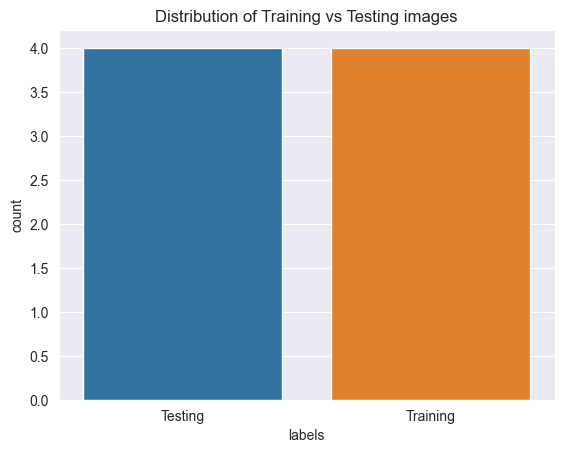

In [24]:
# Look at label distribution (Training vs Testing)
print(df['labels'].value_counts())
sns.countplot(data=df, x='labels')
plt.title("Distribution of Training vs Testing images")
plt.show()

In [25]:
# Add 'tumor' vs 'no_tumor' labels
df['tumor_status'] = df['filepaths'].apply(lambda x: os.path.basename(os.path.dirname(x)))

# Preview new column
print(df[['filepaths', 'labels', 'tumor_status']].head())
 

                                           filepaths    labels tumor_status
0  C:\Users\User\.cache\kagglehub\datasets\masoud...   Testing      Testing
1  C:\Users\User\.cache\kagglehub\datasets\masoud...   Testing      Testing
2  C:\Users\User\.cache\kagglehub\datasets\masoud...   Testing      Testing
3  C:\Users\User\.cache\kagglehub\datasets\masoud...   Testing      Testing
4  C:\Users\User\.cache\kagglehub\datasets\masoud...  Training     Training


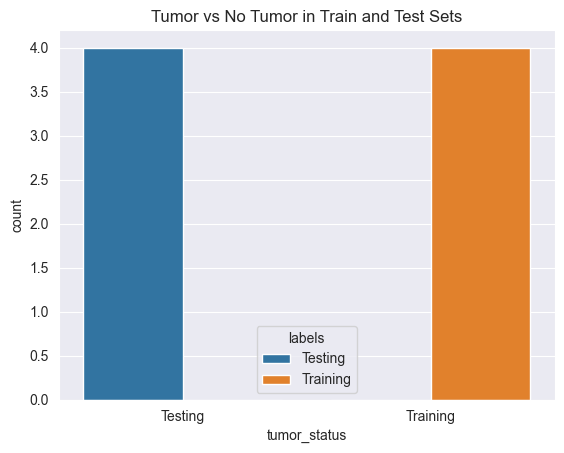

In [26]:
sns.countplot(data=df, x='tumor_status', hue='labels')
plt.title("Tumor vs No Tumor in Train and Test Sets")
plt.show()


In [ ]:
# Check image sizes
dims = df['filepaths'].apply(lambda x: Image.open(x).size)
dims_df = pd.DataFrame(dims.tolist(), columns=['width', 'height'])

# Plot distribution
plt.figure(figsize=(10, 4))
sns.histplot(dims_df['width'], bins=20, color='blue', label='Width', kde=True)
sns.histplot(dims_df['height'], bins=20, color='red', label='Height', kde=True)
plt.title("Image Dimension Distribution")
plt.legend()
plt.show()
